In [1]:
# This is a Python 3 script

# Study the spatial extent of lines detected in COPS-SPIRE

The idea is converting the morphology of line strength into line strength as a function of polar angle.

In [9]:
%matplotlib inline
archive_dir = '/home/bettyjo/yaolun/CDF_archive_v2/'
plotdir = '/home/bettyjo/yaolun/test/cops-spire/'

In [10]:
# object specified parameters
obj = 'BHR71'
# the line of interest
line = 'CO4-3'

# read in the entire fitting table
fitting = ascii.read(archive_dir+'CDF_archive_v2_lines.txt')

In [28]:
# function for getting flux distribution as a function of polar angle with the option of plotting
def PolarFlux(fitting, obj, line, ax=None, normalize=True, max_dist = 60.0,
              color=None, offset=0, verbose=True, interpolate=False, max_ring=1, fold=False):
    from astropy.io import ascii
    import numpy as np

    # select valid detection and exclude the results from 1D spectra
    # exclude the SNR cut at this moment.  A non-detection can be visualized as an upper limit in the plot
    selector = (fitting['Object'] == obj) & (fitting['Pixel_No.'] != 'c') & (fitting['Line'] == line)
    data = fitting[selector]

    if len(data) == 0:
        if verbose:
            print('No data for ', obj)
        return None
    
    # for the lines without valid fitting results or low SNR, modify the strength to be the 5-sigma noise
    data['Str(W/cm2)'][(data['Validity'] != 1)+(data['SNR'] < 5)] = \
        data['Str(W/cm2)'][(data['Validity'] != 1)+(data['SNR'] < 5)]/\
        data['SNR'][(data['Validity'] != 1)+(data['SNR'] < 5)] * 5
    
    # pick the name of the central pixel based on the wavelength of the line
    if (data['ObsWL(um)'][0] <= 310) & (data['ObsWL(um)'][0] >= 195):
        # SSW
        cenpix = 'SSWD4'
    elif (data['ObsWL(um)'][0] > 310):
        # SLW
        cenpix = 'SLWC3'
    else:
        # PACS
        cenpix = '13'
        
    # convert the absolute coordinate into the relative coordinates
    # unit changed from degree to arcsec
    data['RA_offset'] = (data['RA(deg)'] - data['RA(deg)'][data['Pixel_No.'] == cenpix])*\
                        np.cos(np.radians(data['Dec(deg)'][data['Pixel_No.'] == cenpix])) * 3600
    data['Dec_offset'] = (data['Dec(deg)'] - data['Dec(deg)'][data['Pixel_No.'] == cenpix]) * 3600
    
    # treat the coordinates as complex numbers
    # exclude the central spaxel
    coord_complex = np.copy(data['Dec_offset'][data['Pixel_No.'] != cenpix].data).astype(complex)
    coord_complex.imag = data['RA_offset'][data['Pixel_No.'] != cenpix].data
    
    # take the ratio between the fluxes measured in the first ring to the central spaxel
    data_diff = {}
    data_diff['Str'] = data['Str(W/cm2)'][data['Pixel_No.'] != cenpix]/\
                       data['Str(W/cm2)'][data['Pixel_No.'] == cenpix]
    data_diff['Sig_str'] = data_diff['Str']*\
                (1/data['SNR'][data['Pixel_No.'] != cenpix]**2+1/data['SNR'][data['Pixel_No.'] == cenpix]**2)**0.5
        
    # select the first ring or even outer by the distance to the central spaxel
    dist_select = (np.absolute(coord_complex) <= max_dist)
    
    # angle array
    angle = np.angle(coord_complex[dist_select], deg=True)
    sorter = np.argsort(angle)
    
    if normalize:
        data['Str(W/cm2)'] = data['Str(W/cm2)']/data['Str(W/cm2)'].max()
        
    
    # distinguish between detections and non-detections
    detection = (data['SNR'][data['Pixel_No.'] != cenpix][dist_select][sorter] >= 5)
    nondetection = (data['SNR'][data['Pixel_No.'] != cenpix][dist_select][sorter] < 5)

    # calculate the stddev of the flux distribution
    indicator = np.std(data_diff['Str'][dist_select][sorter][detection])

    if verbose:
        print(indicator)

    if len(angle[sorter][detection]) == 0:
        if interpolate:
            ax.plot([], [], marker='None', linestyle='-',label=line, color=color)
        else:
            ax.errorbar([], [], yerr=[], marker='o', linestyle='-',
                        label=line+r', $\sigma=$%4.2f' % (indicator), color=color)
        if verbose:
            print('no detection for ', obj)
        return None

    if (ax is not None) and (interpolate == False):
        # detections
        ax.errorbar(angle[sorter][detection], data_diff['Str'][dist_select][sorter][detection]+offset,
                    yerr=data_diff['Sig_str'][dist_select][sorter][detection],
                    marker='o', linestyle='-', label=line+r', $\sigma=$%4.2f' % (indicator), color=color)

        
    # Perform interpolation on the first/second ring
    if interpolate:
        
        # define the kernel for smoothing
        # the stddev is in the unit of degree
        # normalized Gaussian function
        def gauss_kernel(x, x_cen, sigma):
            return np.exp(-(x-x_cen)**2/2/sigma**2)
        
        # the width of Gaussian smoothing
        stddev = 30
        
        if cenpix == 'SLWC3':
            ring_dist = [50, 90]
        elif cenpix == 'SSWD4':
            # +/- 15
            ring_dist = [33, 60, 90]
        else:
            print('interpolation not yet programed for PACS...')
        
        separators = []
        smooth_ratio = []
        spaxel_dist = np.absolute(coord_complex)
        ring_count = 0
        
        for i in range(len(ring_dist)):
            separators.append((spaxel_dist >= ring_dist[i]-15) & (spaxel_dist <= ring_dist[i]+15))
        
            # the flux ratios from the i-th ring
            detection_dum = (data['SNR'][data['Pixel_No.'] != cenpix][separators[-1]] >= 5)
            angle_ring_dum = np.angle(coord_complex[separators[-1]], deg=True)[detection_dum]
            ratio_ring_dum = data_diff['Str'][separators[-1]][detection_dum]
            ratio_ring_unc_dum = data_diff['Sig_str'][separators[-1]][detection_dum]
        
            if len(angle_ring_dum) == 0:
                if verbose:
                    print('no detection for ', obj)
                return None 
        
            # stitch three angle/ratio/ratio_unc arrays together for the later calculation
            sorter = np.argsort(angle_ring_dum)
            angle_ring_dum = np.hstack((angle_ring_dum[sorter]-360,
                                        angle_ring_dum[sorter],
                                        angle_ring_dum[sorter]+360))
            ratio_ring_dum = np.hstack((ratio_ring_dum[sorter], ratio_ring_dum[sorter], ratio_ring_dum[sorter]))
            ratio_ring_unc_dum = np.hstack((ratio_ring_unc_dum[sorter],
                                            ratio_ring_unc_dum[sorter], 
                                            ratio_ring_unc_dum[sorter]))
        
            angle_dum = np.arange(-180, 180, 0.5)
            smooth_ratio_dum = np.empty_like(angle_dum)
            smooth_ratio_unc_dum = np.empty_like(angle_dum)
            
            for j, a in enumerate(angle_dum):
                smooth_ratio_dum[j] = np.nansum(gauss_kernel(angle_ring_dum, a, stddev) * ratio_ring_dum)
                smooth_ratio_unc_dum[j] = np.nansum((gauss_kernel(angle_ring_dum, a, stddev)*ratio_ring_unc_dum)**2)**0.5
            
            if fold:
                smooth_ratio_dum = (smooth_ratio_dum[angle_dum < 0][::-1] + smooth_ratio_dum[angle_dum >= 0])/2
                smooth_ratio_unc_dum = ((smooth_ratio_unc_dum[angle_dum < 0][::-1])**2+\
                                        (smooth_ratio_unc_dum[angle_dum >= 0])**2)**0.5/2
                angle_dum = angle_dum[angle_dum >= 0]
            
            # calculate the peak-to-valley ratio as an indicator of bipolarity
            # take the peak-to-valley ratio divided by the corresponding uncertainty
#             indicator_val = smooth_ratio_dum.max()/smooth_ratio_dum.min()
#             indicator_unc = indicator_val*\
#                     ((smooth_ratio_unc_dum[smooth_ratio_dum == smooth_ratio_dum.max()]/smooth_ratio_dum.max())**2+\
#                     (smooth_ratio_unc_dum[smooth_ratio_dum == smooth_ratio_dum.min()]/smooth_ratio_dum.min())**2)**0.5
#             indicator = (indicator_val, float(indicator_unc))
            
            if ax is not None:
                ax.plot(angle_dum, smooth_ratio_dum,
                        marker='None', linestyle='-',label=line, color=color)
                ax.fill_between(angle_dum,
                                smooth_ratio_dum-smooth_ratio_unc_dum, smooth_ratio_dum+smooth_ratio_unc_dum,
                                facecolor=color, alpha=0.5)
            
            ring_count += 1
            if ring_count == max_ring:
                break
                
        
        return (coord_complex, indicator, (angle_dum, smooth_ratio_dum, smooth_ratio_unc_dum))
        
        
    return (coord_complex, indicator)


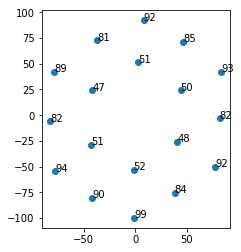

In [287]:
plt.plot(np.real(out[0]), np.imag(out[0]), 'o')
plt.axes().set_aspect('equal')
for i, xy in enumerate(zip(np.real(out[0]), np.imag(out[0]))):
    plt.annotate(int(np.absolute(out[0])[i]), xy=xy, xytext=xy)

In [212]:
obj_list = ['RCrA-IRS7B','RCrA-IRS7C','HH46','L723-MM','L1014',
            'L1157','Ced110','BHR71','IRAS03245','L1551-IRS5',
            'L1455-IRS3','B1-a','B1-c','IRAS03301','TMR1',
            'TMC1A','TMC1','IRAS15398','RNO91','GSS30-IRS1',
            'VLA1623','WL12','RCrA-IRS5A','L483','B335',
            'DKCha']

## SPIRE only

/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in true_divide
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/

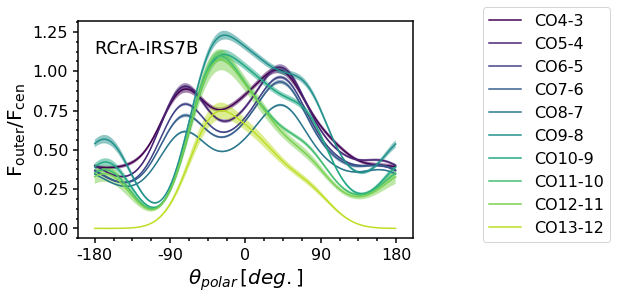

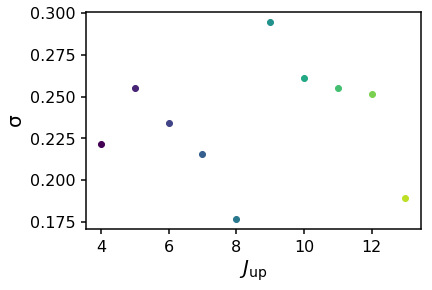

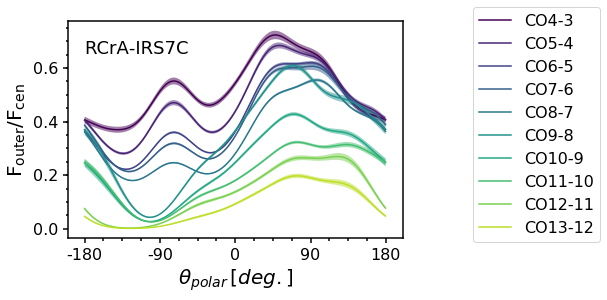

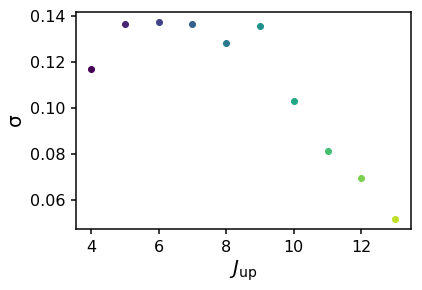

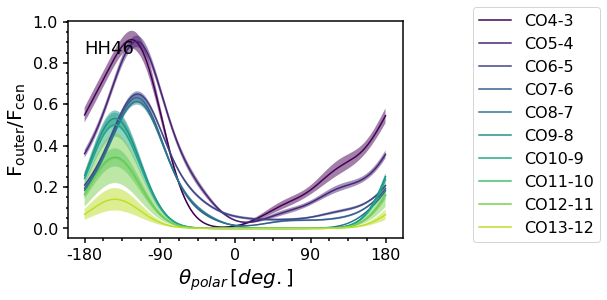

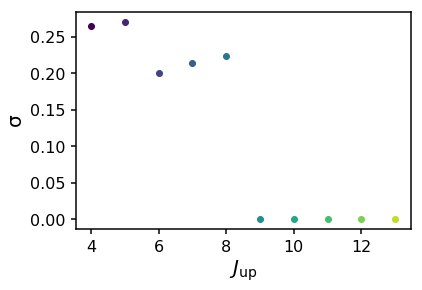

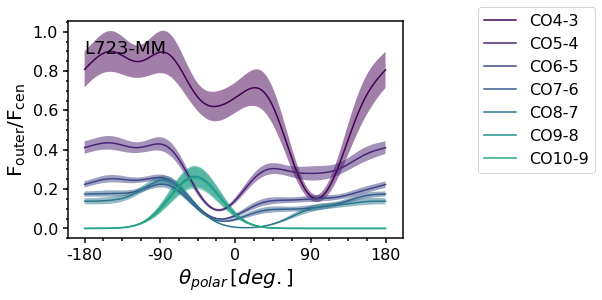

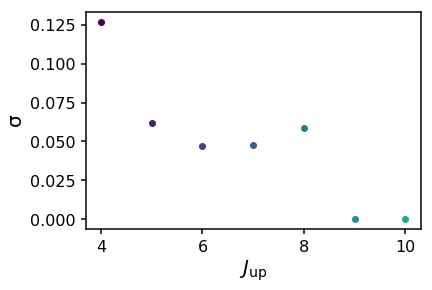

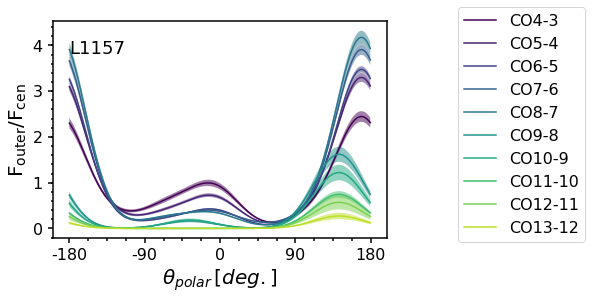

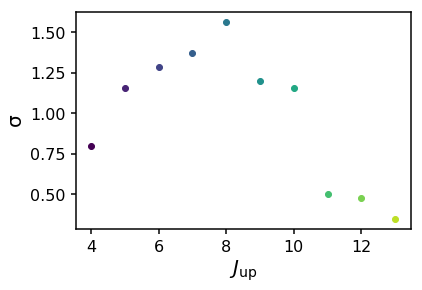

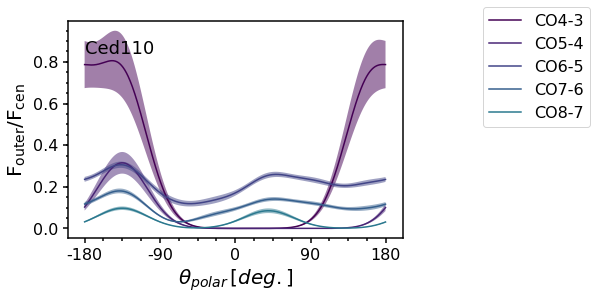

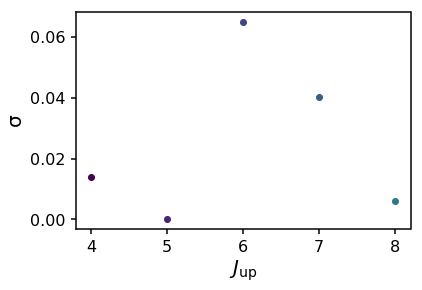

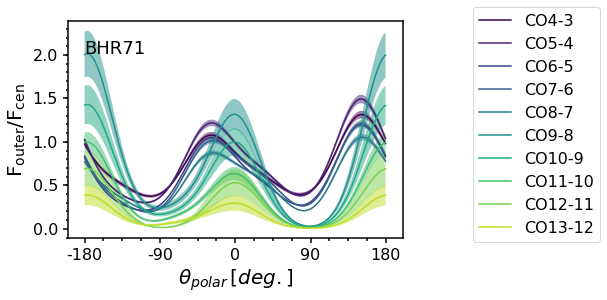

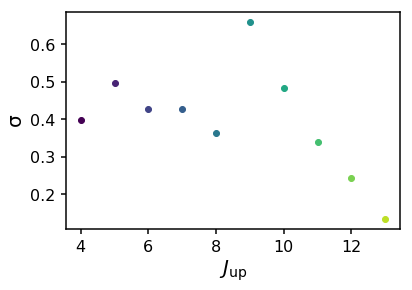

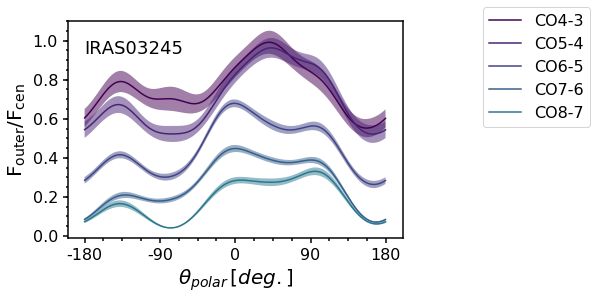

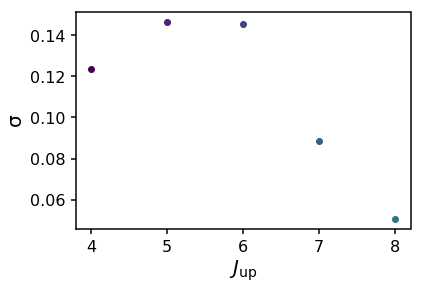

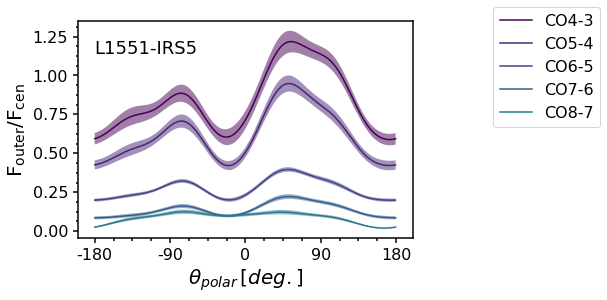

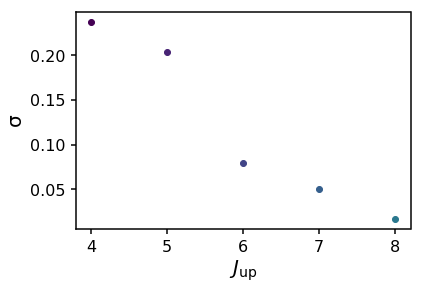

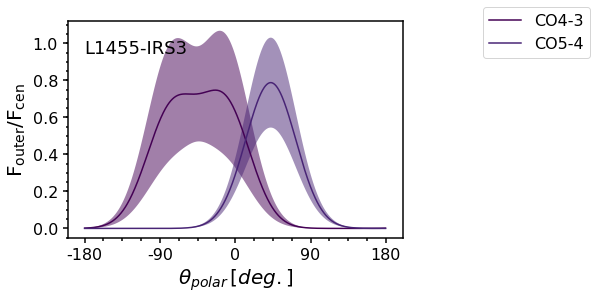

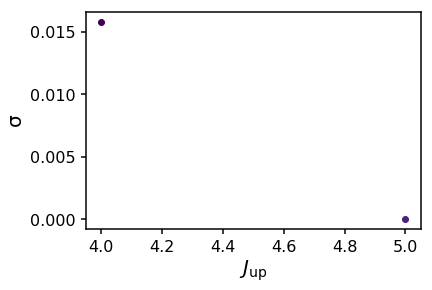

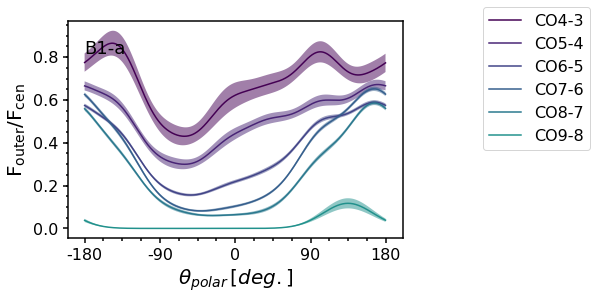

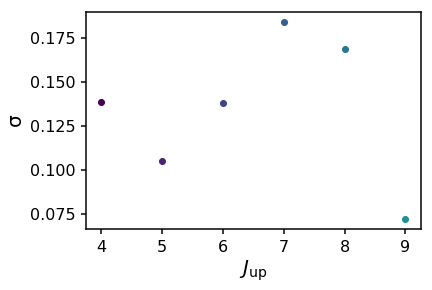

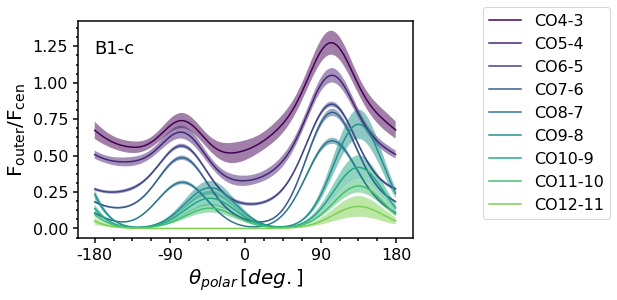

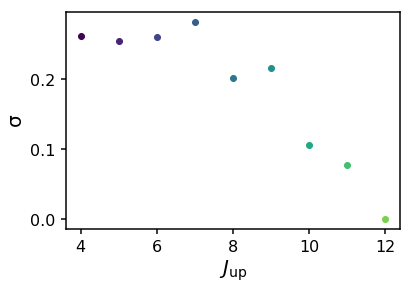

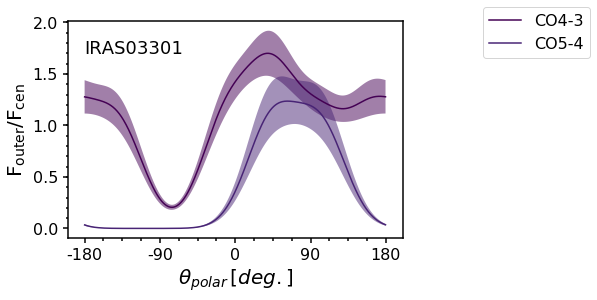

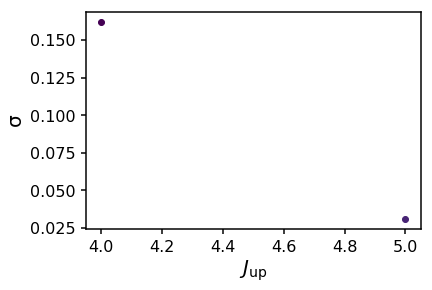

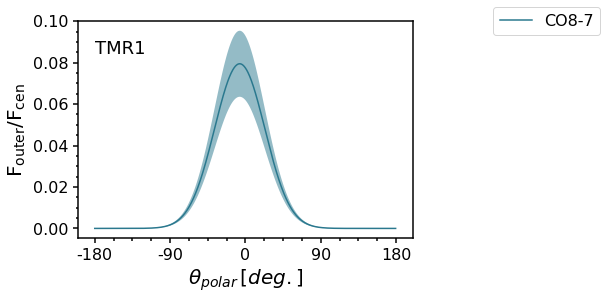

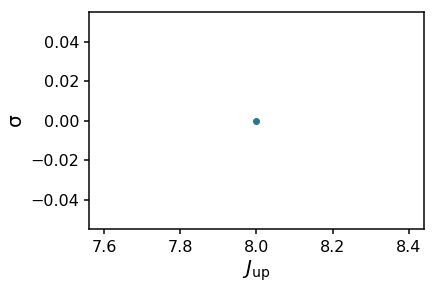

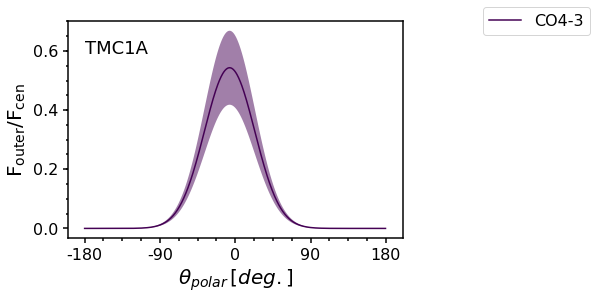

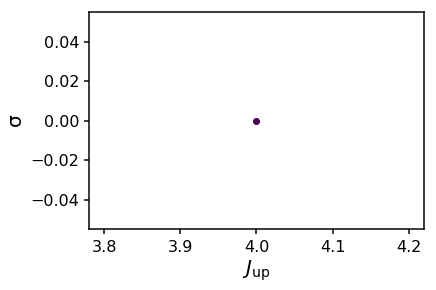

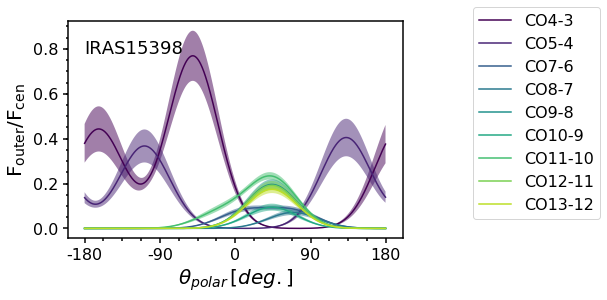

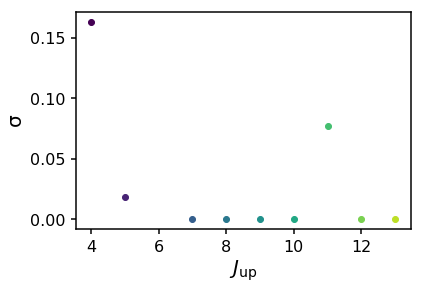

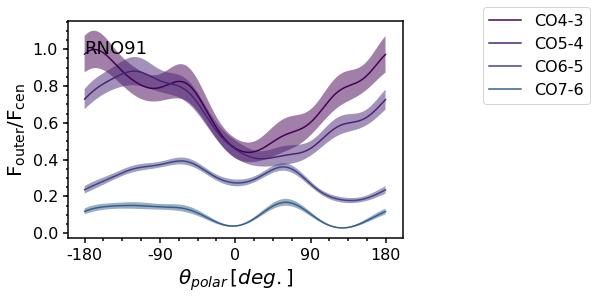

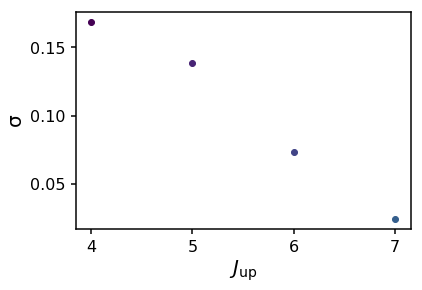

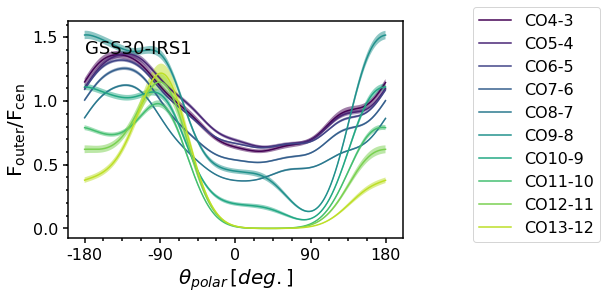

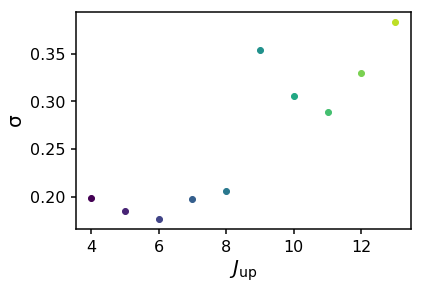

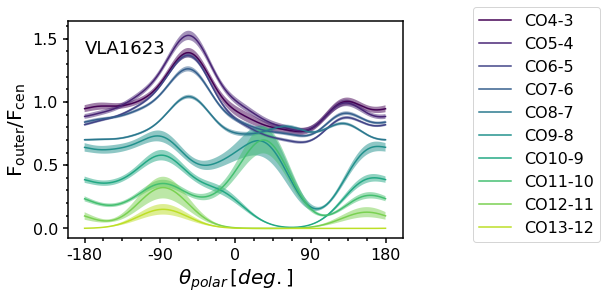

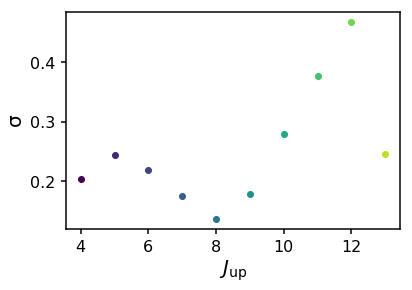

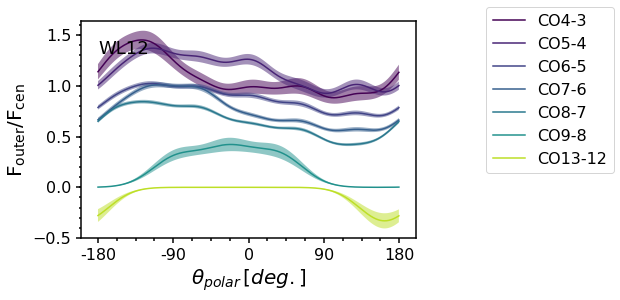

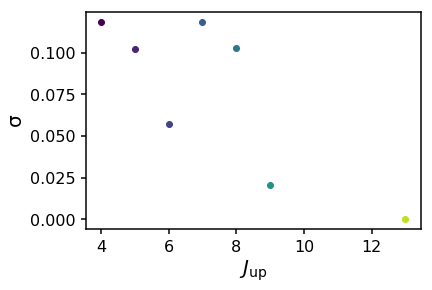

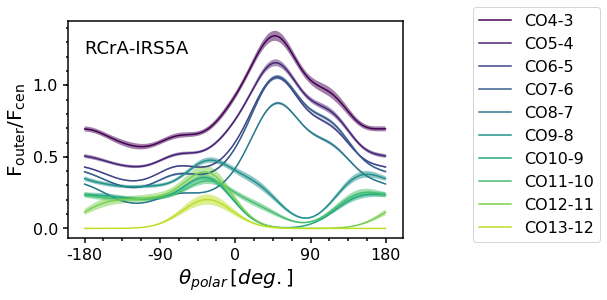

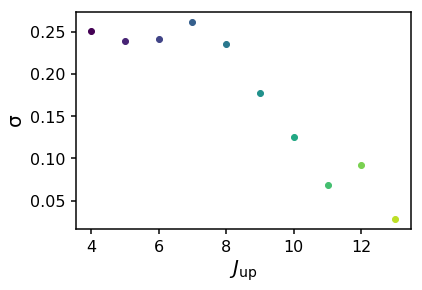

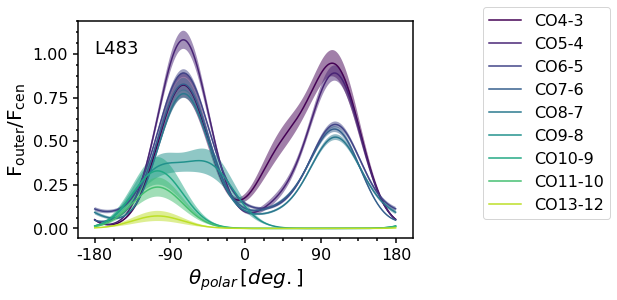

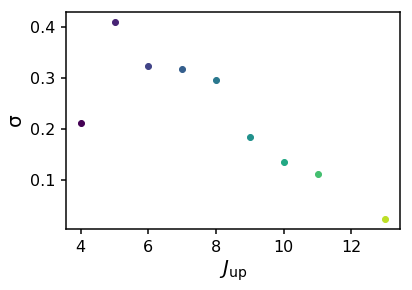

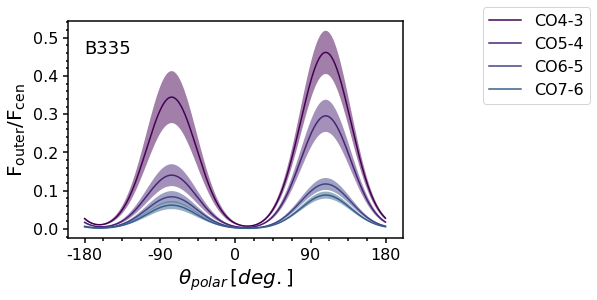

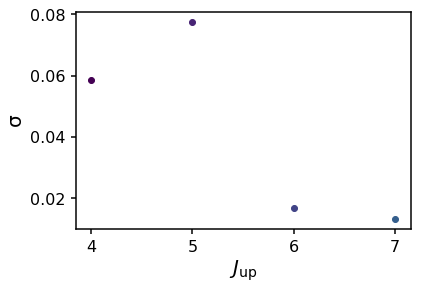

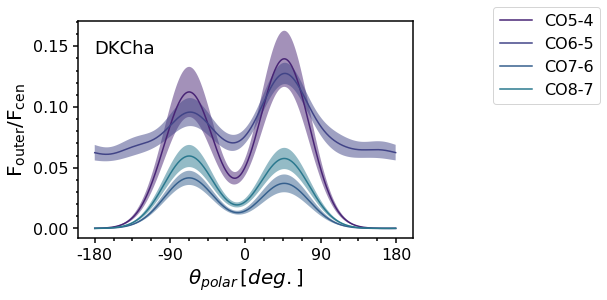

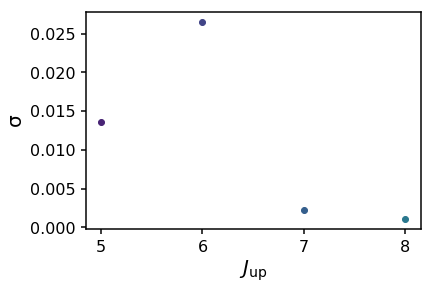

In [395]:
for obj in obj_list:
    
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # another figure for J_up vs. sigma
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    
    linelist = ['CO'+str(i)+'-'+str(i-1) for i in np.arange(4, 14)]
    cmap = plt.cm.viridis
    colorlist = [cmap(np.linspace(0,0.9, len(linelist))[i]) for i in range(len(linelist))]

    
    check4data = 0
    for line in linelist:
        out = PolarFlux(fitting, obj, line, ax=ax, max_dist=60,
                        color=colorlist[linelist.index(line)], offset=linelist.index(line)*0,
                        verbose=False, interpolate=True)
        
        if out is not None:
            # for sigma
            ax2.plot([int(line.split('-')[-1])+1], out[1], 'o',
                     color=colorlist[linelist.index(line)])
            # for peak-to-valley ratio
#             ax2.errorbar([int(line.split('-')[-1])+1], out[1][0], yerr=out[1][1],
#                          marker='o', color=colorlist[linelist.index(line)])
            check4data = 1
            
    if check4data == 0:
        fig.clf()
        fig2.clf()
        continue
        
    ax.set_xlim([-200,200])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels(['-180','-90','0','90','180'])
#     ax.set_xlim([-20,200])
#     ax.set_xticks([0, 45, 90, 135, 180])
#     ax.set_xticklabels(['0','45', '90', '135', '180'])
    ax.text(0.05, 0.85, obj, transform=ax.transAxes, fontsize=18)

    ax.legend(loc='upper center', bbox_to_anchor=(1.4, 1.1), fontsize=16)
    ax.set_xlabel(r'$\theta_{polar}\,[deg.]$', fontsize=20)
    ax.set_ylabel(r'$\rm F_{outer}/F_{cen}$', fontsize=20)
    ax.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=5)
    ax.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=2.5)

    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()

    fig.savefig(plotdir+obj+'_co_spatial_extent_spire.pdf', format='pdf', dpi=300, bbox_inches='tight')
    
    ax2.set_xlabel(r'$J_{\rm up}$', fontsize=20)
    ax2.set_ylabel(r'$\rm \sigma$', fontsize=20)
    ax2.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=5)
    ax2.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=2.5)

    [ax2.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    
    fig2.savefig(plotdir+obj+'_co_spatial_extent_spire_value.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Grid plot of SPIRE

/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in true_divide
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/

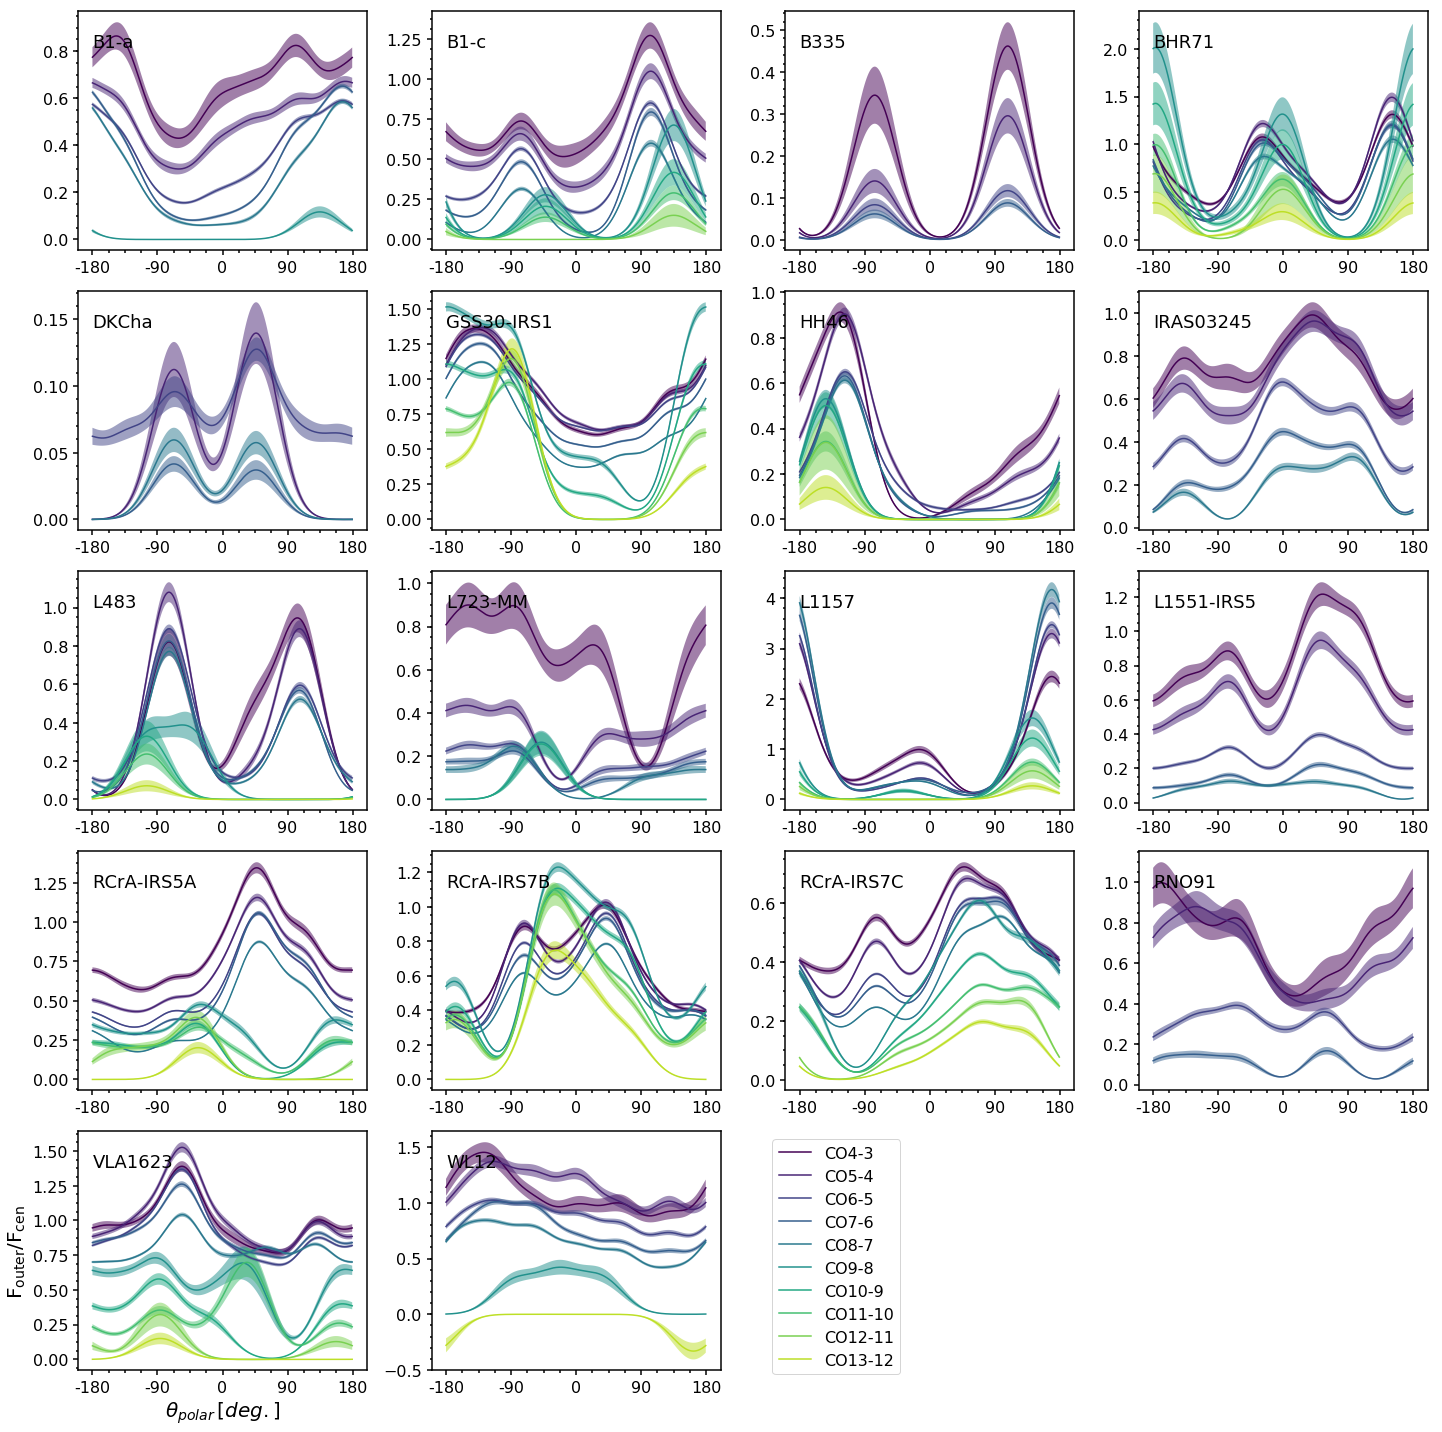

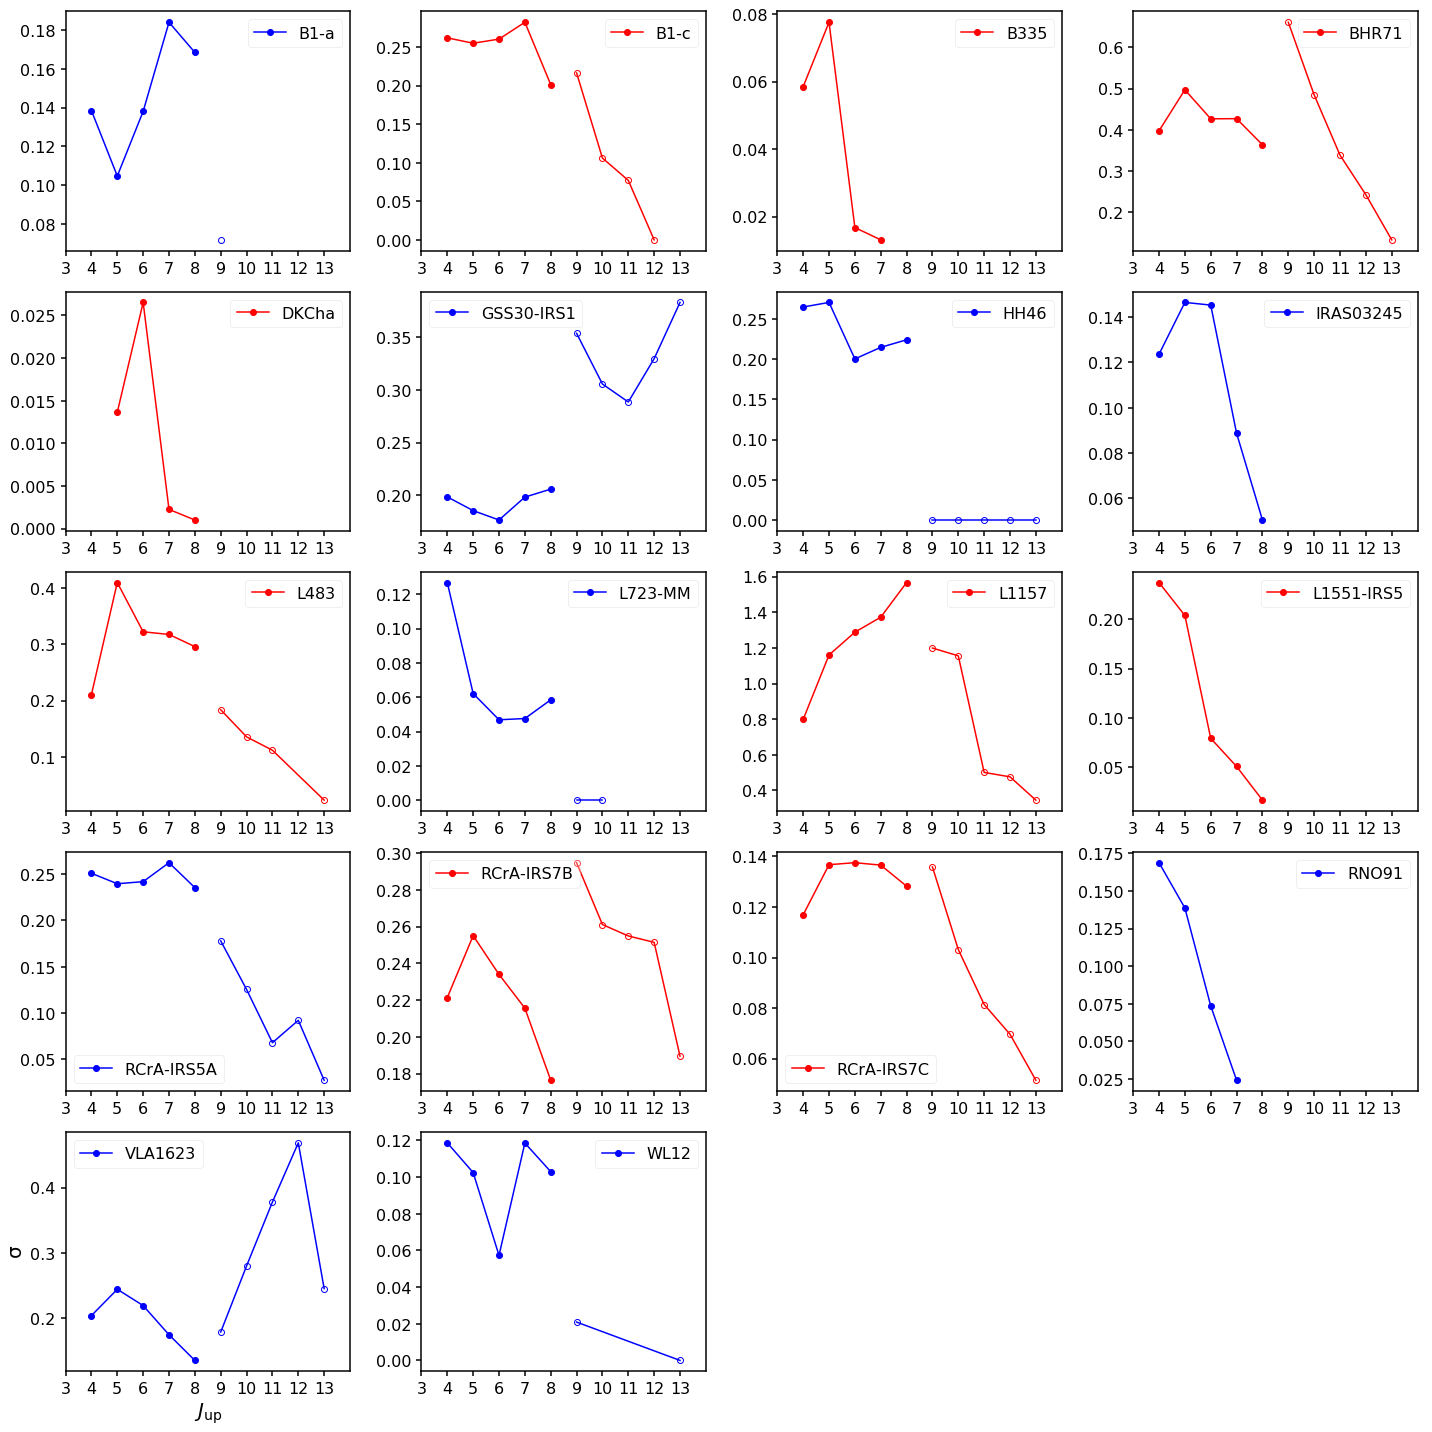

In [33]:
# The objects that have enough detections to make meaningful discussion
obj_select = ['B1-a', 'B1-c', 'B335', 'BHR71', 'DKCha',
              'GSS30-IRS1', 'HH46', 'IRAS03245', 'L483', 'L723-MM',
              'L1157', 'L1551-IRS5', 'RCrA-IRS5A', 'RCrA-IRS7B', 'RCrA-IRS7C',
              'RNO91', 'VLA1623', 'WL12', 'None1', 'None2']

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
import numpy as np

fig, axarr = plt.subplots(5, 4, figsize=(20,20))

# another figure for J_up vs. sigma
fig2, axarr2 = plt.subplots(5, 4, figsize=(20,20))
# fig2 = plt.figure()
# ax2 = fig2.add_subplot(111)
# colorlist_indicator = [plt.cm.CMRmap(np.linspace(0,0.9, len(obj_select[:-2]))[i]) for i in range(len(obj_select[:-2]))]

# misc for plotting
linelist = ['CO'+str(i)+'-'+str(i-1) for i in np.arange(4, 14)]
cmap = plt.cm.viridis
colorlist = [cmap(np.linspace(0,0.9, len(linelist))[i]) for i in range(len(linelist))]

for obj in obj_select:
    
    ax = axarr[int(obj_select.index(obj))//int(4), obj_select.index(obj)%4]
    ax2 = axarr2[int(obj_select.index(obj))//int(4), obj_select.index(obj)%4]
    
    # disable the usused axes
    if len(obj.split('None')[0]) == 0:
        ax.axis('off')
        ax2.axis('off')
        continue

    check4data = 0
    Jup_list = []
    indicator_list = []
    for line in linelist:
        out = PolarFlux(fitting, obj, line, ax=ax, max_dist=60,
                        color=colorlist[linelist.index(line)], offset=linelist.index(line)*0,
                        verbose=False, interpolate=True)
        
        if out is not None:
            # for indicator
            Jup_list.append(int(line.split('-')[-1])+1)
            indicator_list.append(out[1])
            check4data = 1
            
    Jup_list = np.array(Jup_list)
    indicator_list = np.array(indicator_list)
    
    std_color = 'b'
    # plot in red for sources with two peak feature
    if obj in ['B1-c', 'B335', 'BHR71', 'DKCha', 'L483', 'L1157', 'L1551-IRS5', 'RCrA-IRS7B', 'RCrA-IRS7C']:
        std_color = 'r'
    
    ax2.plot(Jup_list[Jup_list <= 8], indicator_list[Jup_list <= 8], marker='o', linestyle='-', 
             color=std_color, label=obj)
    ax2.plot(Jup_list[Jup_list > 8], indicator_list[Jup_list > 8], marker='o', linestyle='-', 
             color=std_color, mfc='None')

#     ax.set_aspect('equal')
    ax.set_xlim([-200,200])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels(['-180','-90','0','90','180'])
    ax.text(0.05, 0.85, obj, transform=ax.transAxes, fontsize=18)

    if obj_select.index(obj) == 17:
        ax.legend(loc='upper center', bbox_to_anchor=(1.4, 1), fontsize=16)
    if obj_select.index(obj) == 16:
        ax.set_xlabel(r'$\theta_{polar}\,[deg.]$', fontsize=20)
        ax.set_ylabel(r'$\rm F_{outer}/F_{cen}$', fontsize=20)
    ax.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=5)
    ax.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=2.5)

    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    
    # ax2
    if obj_select.index(obj) == 16:
        ax2.set_xlabel(r'$J_{\rm up}$', fontsize=20)
        ax2.set_ylabel(r'$\rm \sigma$', fontsize=20)
        
    lg_pos = 'best'
    if obj == 'GSS30-IRS1': lg_pos = 'upper left'
    if obj == 'RCrA-IRS7B': lg_pos = 'upper left'
    ax2.legend(loc=lg_pos, numpoints=1, fontsize=16, framealpha=0.3)
    ax2.set_xlim([3,14])
    ax2.set_xticks(np.arange(3,14))
    ax2.set_xticklabels(np.arange(3,14).astype('str'))
    ax2.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=5)
    ax2.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=2.5)

    [ax2.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]

fig.tight_layout()
fig.savefig(plotdir+'co_spatial_extent_spire.pdf', format='pdf', dpi=300, bbox_inches='tight')

fig2.tight_layout()
fig2.savefig(plotdir+'co_spatial_extent_spire_value.pdf', format='pdf', dpi=300, bbox_inches='tight')
    

## PACS only

/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in true_divide
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/bettyjo/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/bettyjo/yaolun/anaconda/envs/astro

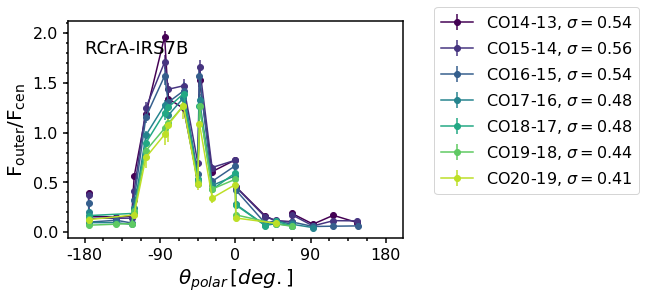

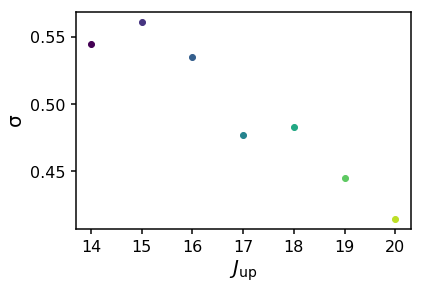

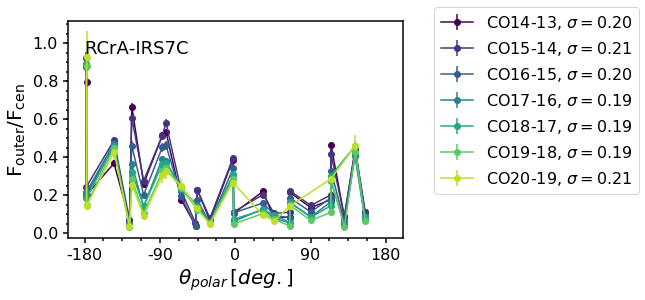

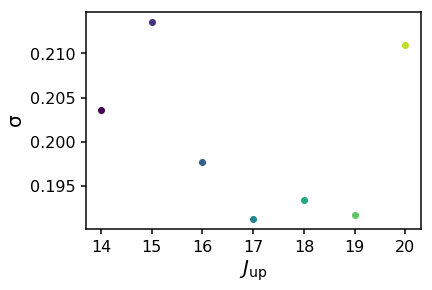

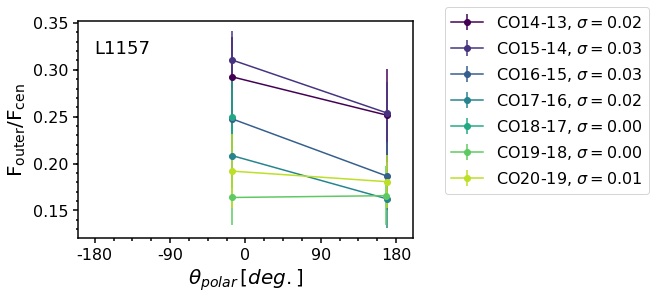

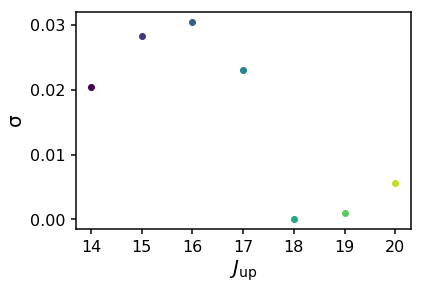

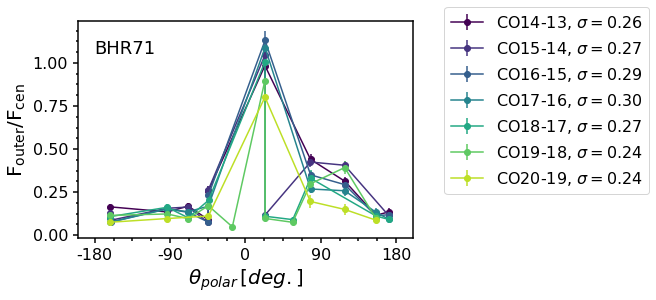

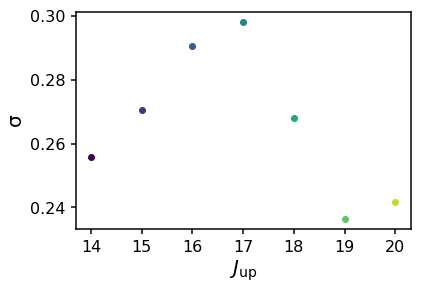

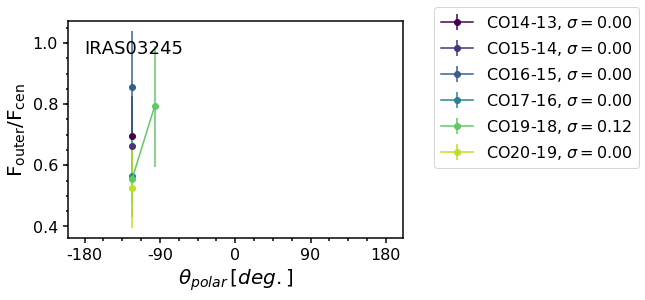

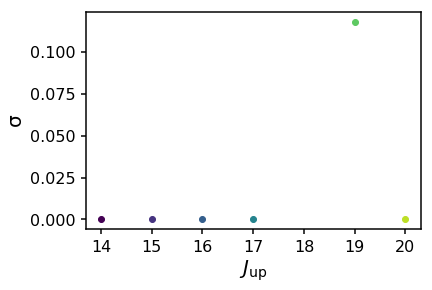

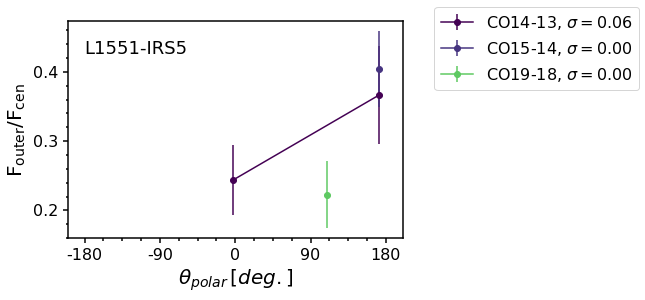

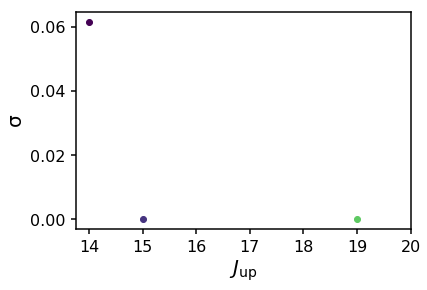

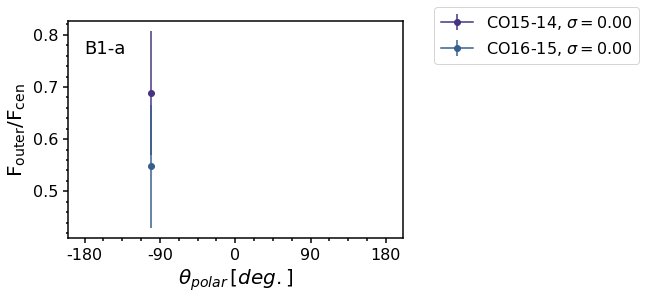

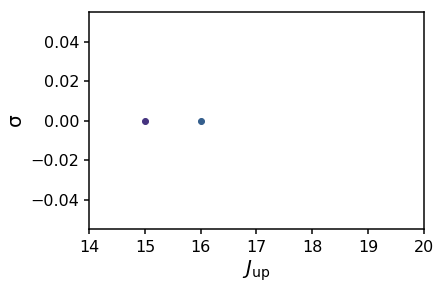

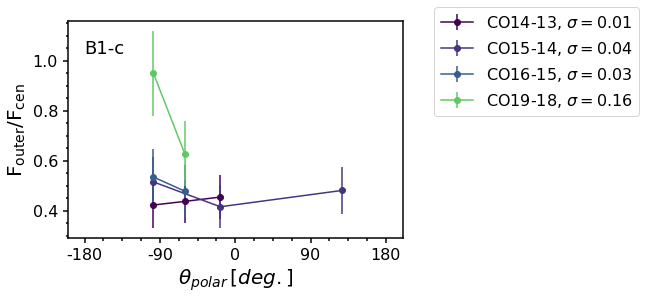

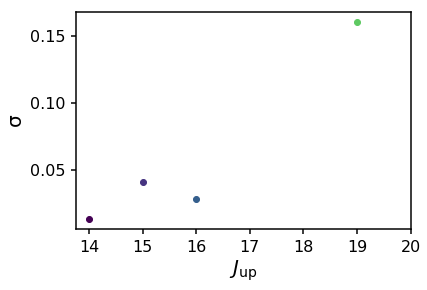

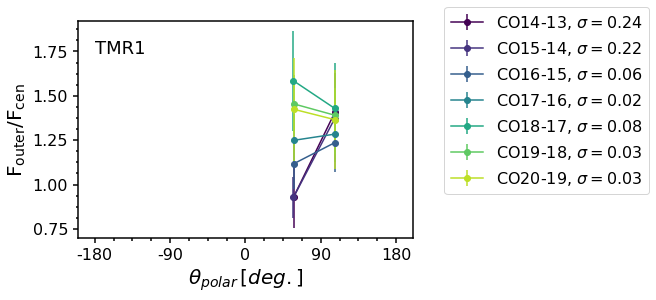

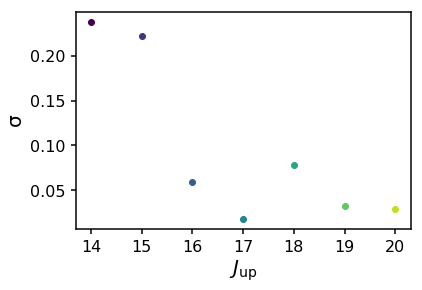

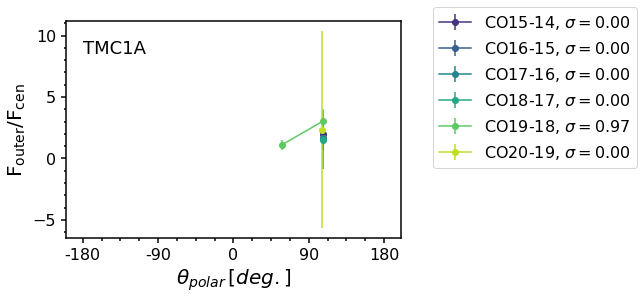

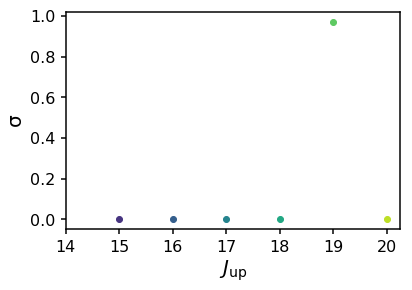

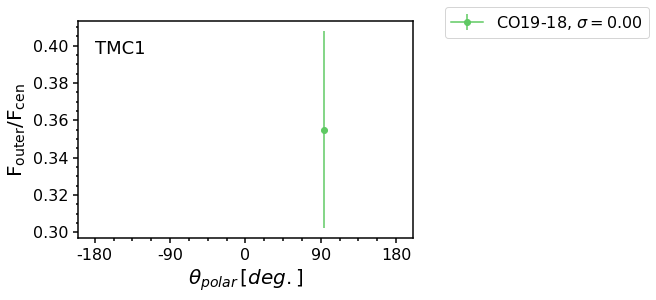

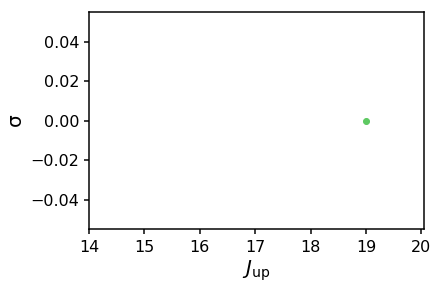

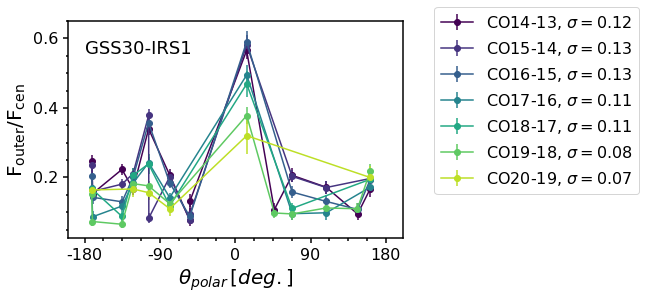

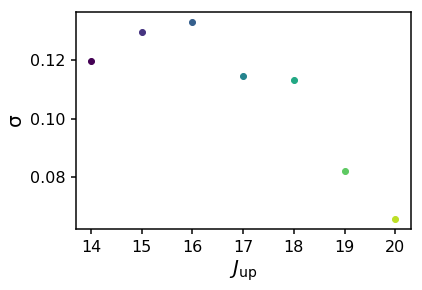

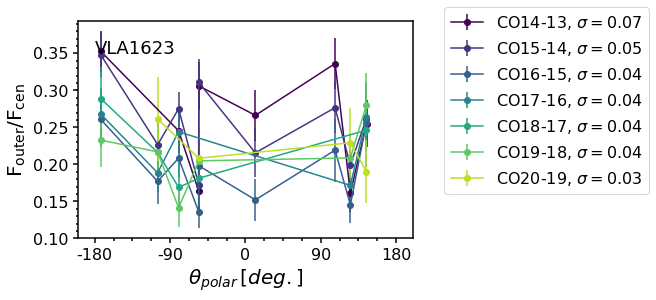

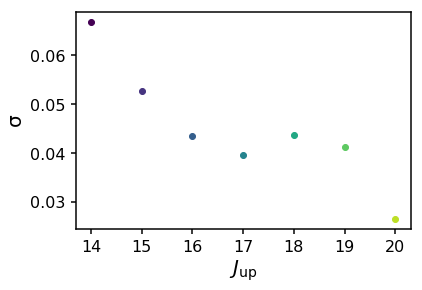

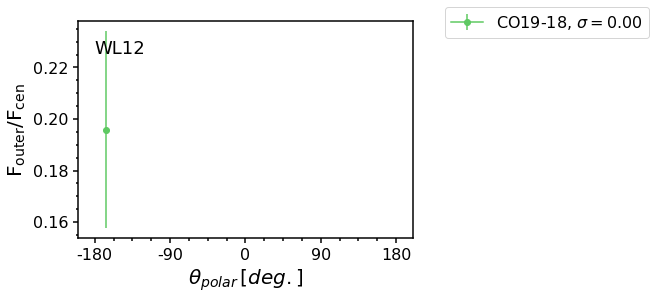

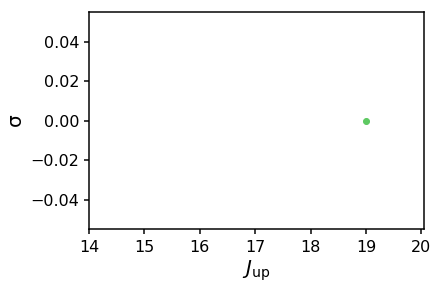

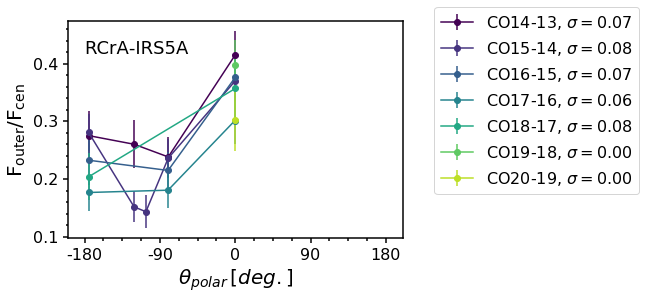

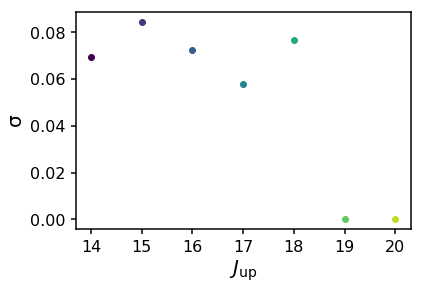

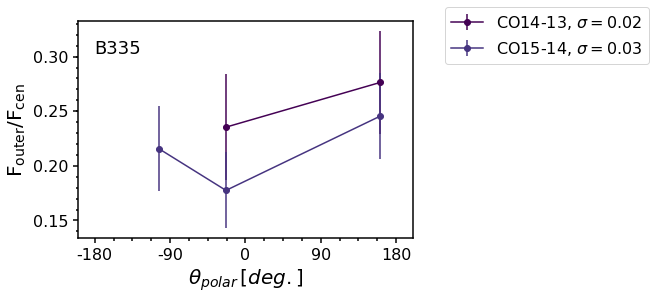

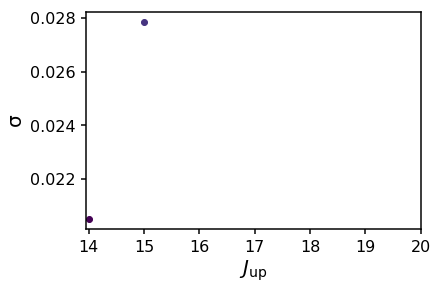

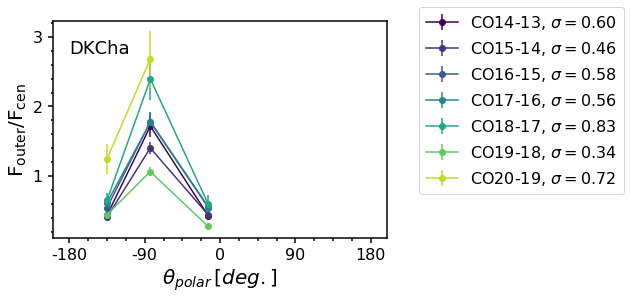

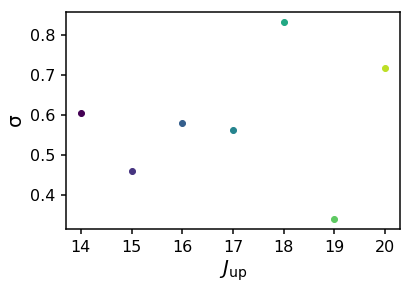

In [260]:
for obj in obj_list:
    
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # another figure for J_up vs. sigma
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    
    linelist = ['CO'+str(i)+'-'+str(i-1) for i in np.arange(14, 21)]
    cmap = plt.cm.viridis
    colorlist = [cmap(np.linspace(0,0.9, len(linelist))[i]) for i in range(len(linelist))]

    
    check4data = 0
    for line in linelist:
        out = PolarFlux(fitting, obj, line, ax=ax, max_dist=60,
                        color=colorlist[linelist.index(line)], offset=linelist.index(line)*0, verbose=False)

        if out is not None:
            ax2.plot([int(line.split('-')[-1])+1], out[2], 'o',
                     color=colorlist[linelist.index(line)])
            check4data = 1
            
    if check4data == 0:
        fig.clf()
        fig2.clf()
        continue
        
    ax.set_xlim([-200,200])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels(['-180','-90','0','90','180'])
    ax.text(0.05, 0.85, obj, transform=ax.transAxes, fontsize=18)

    ax.legend(loc='upper center', bbox_to_anchor=(1.4, 1.1), fontsize=16)
    ax.set_xlabel(r'$\theta_{polar}\,[deg.]$', fontsize=20)
    ax.set_ylabel(r'$\rm F_{outer}/F_{cen}$', fontsize=20)
    ax.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=5)
    ax.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=2.5)

    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()

    fig.savefig(plotdir+obj+'_co_spatial_extent_pacs.pdf', format='pdf', dpi=300, bbox_inches='tight')
    
    ax2.set_xticks([14,15,16,17,18,19,20])
    ax2.set_xticklabels(['14','15','16','17','18','19','20'])
    ax2.set_xlabel(r'$J_{\rm up}$', fontsize=20)
    ax2.set_ylabel(r'$\rm \sigma$', fontsize=20)
    ax2.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=5)
    ax2.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=2.5)

    [ax2.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    
    fig2.savefig(plotdir+obj+'_co_spatial_extent_pacs_value.pdf', format='pdf', dpi=300, bbox_inches='tight')